In [7]:
%pip install matplotlib numpy imageio 

Note: you may need to restart the kernel to use updated packages.


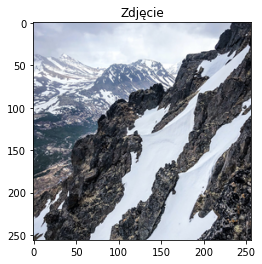

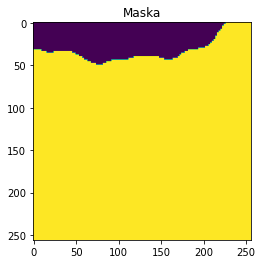

Kształt obrazów: (78958, 256, 256, 3)
Kształt masek: (78958, 256, 256, 1)


In [1]:
# Importowanie niezbędnych bibliotek do pracy z tablicami i wizualizacji
import numpy as np 
import matplotlib.pyplot as plt

# Ładowanie obrazów i masek z plików .npy
images, masks = (np.load('images.npy', mmap_mode='r'),
                 np.load('masks.npy', mmap_mode='r')
)

# Wyświetlanie pierwszego obrazu i jego maski w celu sprawdzenia danych
plt.imshow(images[0])
plt.title('Zdjęcie')
plt.show()

plt.imshow(masks[0])
plt.title('Maska')
plt.show()

# Sprawdzanie kształtu tablic obrazów i masek
print(f"Kształt obrazów: {images.shape}")
print(f"Kształt masek: {masks.shape}")


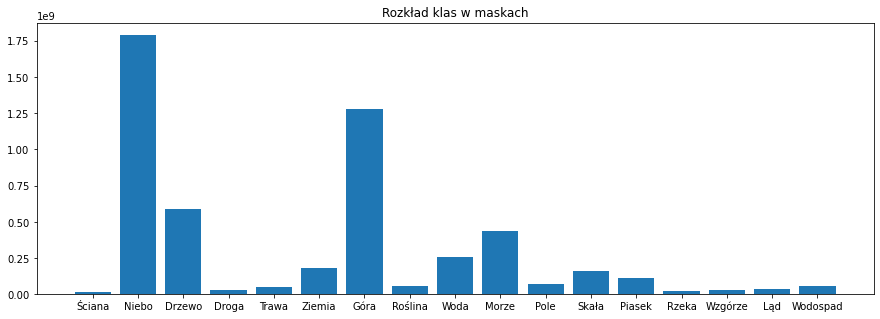

In [2]:
# Lista z nazwami klas i ich indeksami dla segmentacji
class_names = [
    {"name": "Ściana", "classIndex": 0, "ADE20K_classIndex": 0},
    {"name": "Niebo", "classIndex": 1, "ADE20K_classIndex": 2},
    {"name": "Drzewo", "classIndex": 2, "ADE20K_classIndex": 4},
    {"name": "Droga", "classIndex": 3, "ADE20K_classIndex": 6},
    {"name": "Trawa", "classIndex": 4, "ADE20K_classIndex": 9},
    {"name": "Ziemia", "classIndex": 5, "ADE20K_classIndex": 13},
    {"name": "Góra", "classIndex": 6, "ADE20K_classIndex": 16},
    {"name": "Roślina", "classIndex": 7, "ADE20K_classIndex": 17},
    {"name": "Woda", "classIndex": 8, "ADE20K_classIndex": 21},
    {"name": "Morze", "classIndex": 9, "ADE20K_classIndex": 26},
    {"name": "Pole", "classIndex": 10, "ADE20K_classIndex": 29},
    {"name": "Skała", "classIndex": 11, "ADE20K_classIndex": 34},
    {"name": "Piasek", "classIndex": 12, "ADE20K_classIndex": 46},
    {"name": "Rzeka", "classIndex": 13, "ADE20K_classIndex": 60},
    {"name": "Wzgórze", "classIndex": 14, "ADE20K_classIndex": 68},
    {"name": "Ląd", "classIndex": 15, "ADE20K_classIndex": 94},
    {"name": "Wodospad", "classIndex": 16, "ADE20K_classIndex": 113},
]

# Pokazywanie rozkładu klas w maskach
classes = np.unique(masks, return_counts=True)

plt.figure(figsize=(15, 5))
plt.bar(classes[0], classes[1])
plt.xticks(classes[0], [class_names[i]["name"] for i in classes[0]])
plt.title('Rozkład klas w maskach')
plt.show()


In [3]:
# Definiowanie indeksów klas dla "Góra" i "Morze"
MOUNTAIN_CLASS_INDEX = 6
SEA_CLASS_INDEX = 9

# Tworzenie binarnych masek dla klas "Góra" i "Morze"
masks_mountain_sea = np.isin(masks, [MOUNTAIN_CLASS_INDEX, SEA_CLASS_INDEX]).astype(np.uint8)

# Konwertowanie masek: 1 dla gór, 2 dla morza, 0 dla innych klas
masks_mountain_sea = np.where(masks == MOUNTAIN_CLASS_INDEX, 1, masks_mountain_sea)
masks_mountain_sea = np.where(masks == SEA_CLASS_INDEX, 2, masks_mountain_sea)


In [4]:
# Podział danych na zestawy treningowe, walidacyjne i testowe
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(range(len(images)), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

# Tworzenie zestawów danych
X_train, X_val, X_test = images[train_indices], images[val_indices], images[test_indices]
y_train, y_val, y_test = masks_mountain_sea[train_indices], masks_mountain_sea[val_indices], masks_mountain_sea[test_indices]


In [5]:
# Funkcja do obliczania wskaźnika Jaccarda (IoU) dla danej klasy
def jaccard_index(y_true, y_pred, class_index):
    """
    Oblicza wskaźnik Jaccarda (IoU) dla określonej klasy.
    
    Parametry:
    - y_true: Prawdziwa maska binarna dla klasy
    - y_pred: Przewidywana maska binarna dla tej samej klasy
    - class_index: Indeks klasy w masce
    
    Zwraca:
    - Wskaźnik Jaccarda dla określonej klasy
    """
    intersection = np.logical_and(y_true == class_index, y_pred == class_index).sum()
    union = np.logical_or(y_true == class_index, y_pred == class_index).sum()
    return intersection / union if union != 0 else 0

# Użycie prawdziwych masek jako przewidywanych (przykład)
y_pred_test = y_test

# Obliczanie wskaźnika Jaccarda dla klas "Góra" i "Morze"
jaccard_mountain = np.mean([jaccard_index(y_true, y_pred, 1) for y_true, y_pred in zip(y_test, y_pred_test)])
jaccard_sea = np.mean([jaccard_index(y_true, y_pred, 2) for y_true, y_pred in zip(y_test, y_pred_test)])

print(f"Wskaźnik Jaccarda dla klasy 'Góra': {jaccard_mountain:.4f}")
print(f"Wskaźnik Jaccarda dla klasy 'Morze': {jaccard_sea:.4f}")


Wskaźnik Jaccarda dla klasy 'Góra': 0.6660
Wskaźnik Jaccarda dla klasy 'Morze': 0.2460


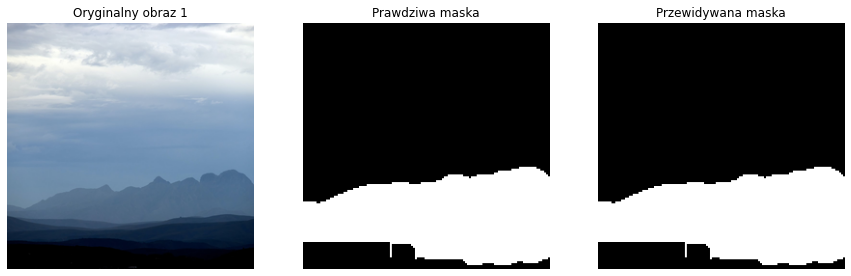

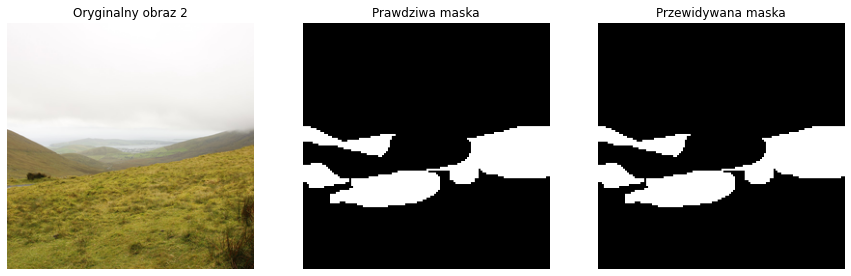

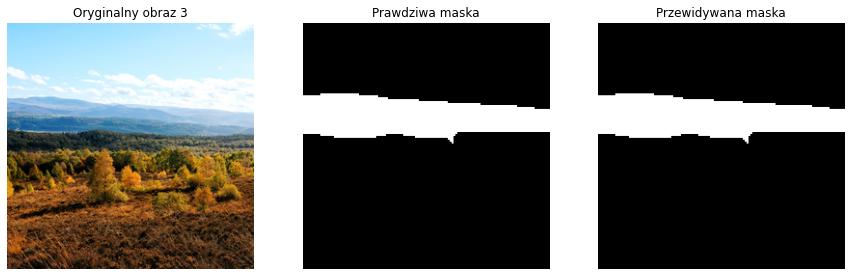

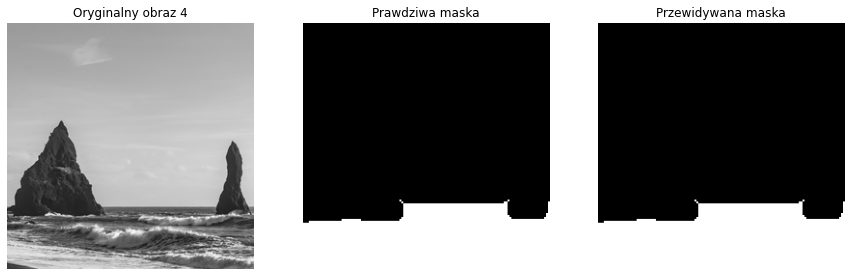

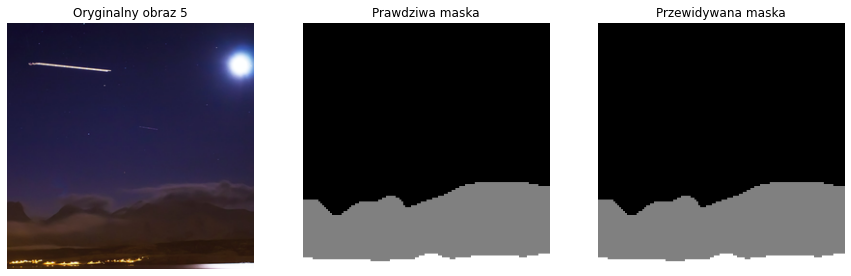

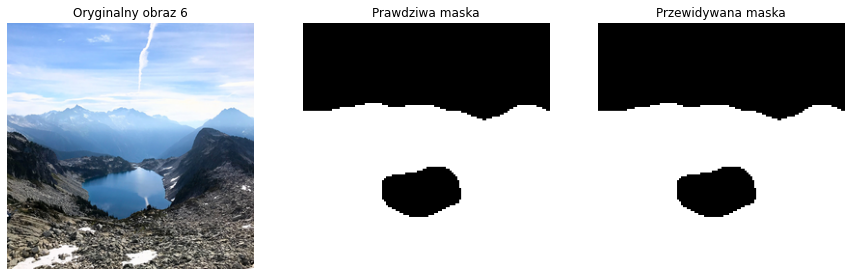

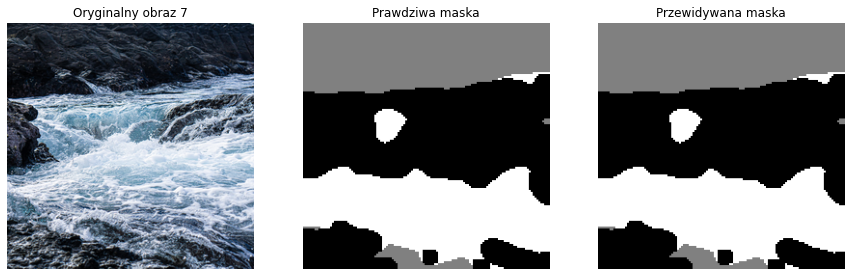

In [6]:
# Funkcja do wyświetlania wyników segmentacji
def plot_segmentation_results(image, true_mask, pred_mask, index):
    """
    Funkcja do wyświetlania oryginalnego obrazu, prawdziwej maski i przewidywanej maski.
    
    Parametry:
    - image: Oryginalny obraz
    - true_mask: Prawdziwa maska
    - pred_mask: Przewidywana maska
    - index: Indeks obrazu
    """
    plt.figure(figsize=(15, 5))
    
    # Oryginalny obraz
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Oryginalny obraz {index}')
    plt.axis('off')
    
    # Prawdziwa maska
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('Prawdziwa maska')
    plt.axis('off')
    
    # Przewidywana maska
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Przewidywana maska')
    plt.axis('off')
    
    plt.show()

# Wyświetlanie pierwszych kilku wyników
for i in range(1, 8):
    plot_segmentation_results(X_test[i], y_test[i], y_pred_test[i], i)

## Podsumowanie:
- W tym projekcie zrealizowaliśmy proces segmentacji obrazów w celu wyróżnienia obiektów określonych klas, takich jak "Góra" i "Morze". Podzieliliśmy dane na zestawy treningowe, walidacyjne i testowe oraz oceniliśmy wydajność za pomocą wskaźnika Jaccarda (IoU). Ta metryka pozwoliła obiektywnie ocenić dokładność segmentacji. Wyniki można wykorzystać do dalszych usprawnień modelu lub analizy.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# Подготовка данных
subset_size = 100  # уменьшаем объем данных для экономии памяти
images = images[:subset_size] / 255.0
masks = masks[:subset_size]

# Преобразование масок в формат one-hot
num_classes = np.max(masks) + 1
masks_categorical = to_categorical(masks, num_classes=num_classes)

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(images, masks_categorical, test_size=0.2, random_state=42)

def unet_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Слои энкодера
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Боттлнек
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Слои декодера с апсемплингом
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Выходной слой
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Создание и компиляция модели
input_shape = (images.shape[1], images.shape[2], images.shape[3])
model = unet_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=2)

# Предсказание и расчет IoU
y_pred = model.predict(X_val)
# Подсчитайте метрику IoU для классов


Epoch 1/10
40/40 [==============================] - 165s 4s/step - loss: 2.3058 - accuracy: 0.2599 - val_loss: 1.9750 - val_accuracy: 0.2157
Epoch 2/10
40/40 [==============================] - 168s 4s/step - loss: 2.0112 - accuracy: 0.3122 - val_loss: 2.0397 - val_accuracy: 0.3883
Epoch 3/10
40/40 [==============================] - 168s 4s/step - loss: 2.0026 - accuracy: 0.3066 - val_loss: 1.9909 - val_accuracy: 0.3882
Epoch 4/10
40/40 [==============================] - 169s 4s/step - loss: 1.9954 - accuracy: 0.2722 - val_loss: 2.0240 - val_accuracy: 0.3875
Epoch 5/10
40/40 [==============================] - 171s 4s/step - loss: 2.0145 - accuracy: 0.2882 - val_loss: 2.0309 - val_accuracy: 0.3883
Epoch 6/10
40/40 [==============================] - 171s 4s/step - loss: 1.9747 - accuracy: 0.3039 - val_loss: 2.0331 - val_accuracy: 0.2175
Epoch 7/10
40/40 [==============================] - 172s 4s/step - loss: 2.0158 - accuracy: 0.2958 - val_loss: 2.0583 - val_accuracy: 0.3883
Epoch 8/10
40

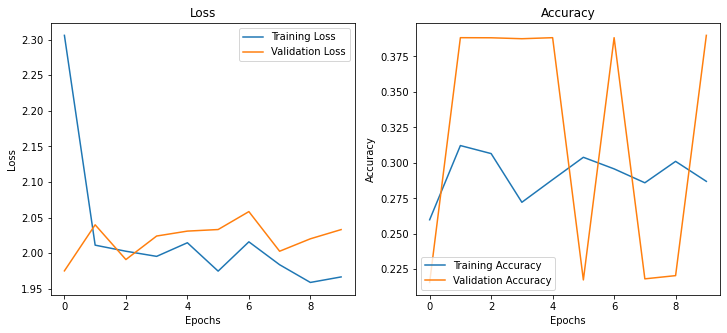

In [8]:
# Построение графиков обучения
plt.figure(figsize=(12, 5))

# Потери
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [11]:
def calculate_iou(y_true, y_pred, num_classes):
    iou_scores = []
    y_true = np.argmax(y_true, axis=-1)  # Преобразование в формат классов
    y_pred = np.argmax(y_pred, axis=-1)

    for cls in range(num_classes):
        intersection = np.sum((y_true == cls) & (y_pred == cls))
        union = np.sum((y_true == cls) | (y_pred == cls))
        iou = intersection / (union + 1e-6)  # Добавляем малое значение для избежания деления на ноль
        iou_scores.append(iou)

        print(f"IoU dla klasy {cls}: {iou:.4f}")

    return iou_scores

iou_scores = calculate_iou(y_val, y_pred, num_classes=num_classes)


IoU dla klasy 0: 0.0000
IoU dla klasy 1: 0.0105
IoU dla klasy 2: 0.0000
IoU dla klasy 3: 0.0000
IoU dla klasy 4: 0.0000
IoU dla klasy 5: 0.0000
IoU dla klasy 6: 0.3888
IoU dla klasy 7: 0.0000
IoU dla klasy 8: 0.0000
IoU dla klasy 9: 0.0000
IoU dla klasy 10: 0.0000
IoU dla klasy 11: 0.0000
IoU dla klasy 12: 0.0000
IoU dla klasy 13: 0.0000
IoU dla klasy 14: 0.0000
IoU dla klasy 15: 0.0000
IoU dla klasy 16: 0.0000


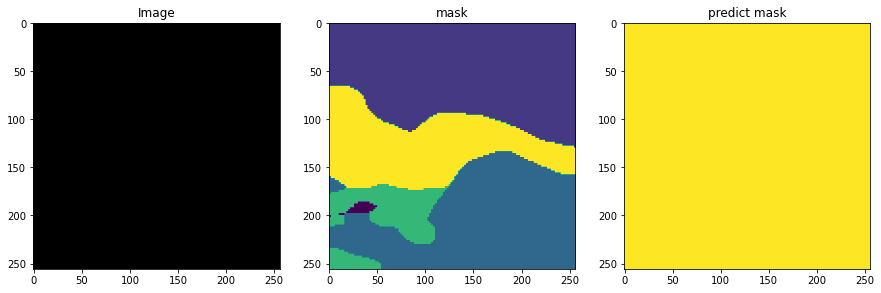

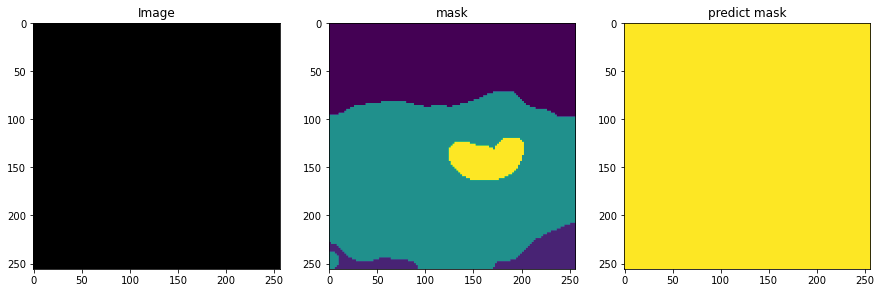

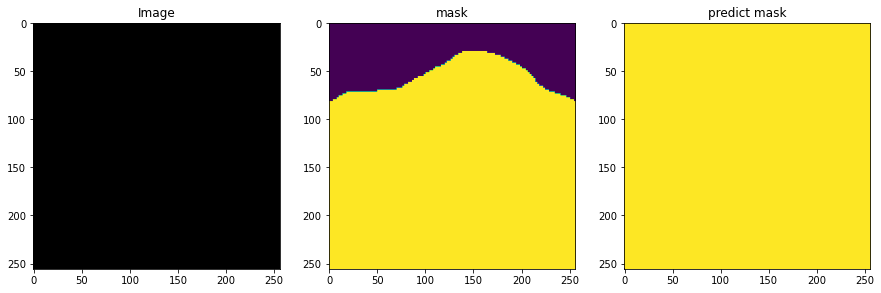

In [12]:
# Визуализация предсказаний и истинных масок
num_examples = 3  # Количество примеров для визуализации
for i in range(num_examples):
    plt.figure(figsize=(15, 5))

    # Исходное изображение
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title('Image')

    # Истинная маска
    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(y_val[i], axis=-1))
    plt.title('mask')

    # Предсказанная маска
    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(y_pred[i], axis=-1))
    plt.title('predict mask')

    plt.show()
